# Decision Trees from Scratch

#### Necessary Imports

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Data

In [3]:
loans = pd.read_csv("lending-club-data.csv")
loans.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,is_inc_v,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,not_compliant,status,inactive_loans,bad_loans,emp_length_num,grade_num,sub_grade_num,delinq_2yrs_zero,pub_rec_zero,collections_12_mths_zero,short_emp,payment_inc_ratio,final_d,last_delinq_none,last_record_none,last_major_derog_none
0,1077501,1296599,5000,5000,4975,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,20111201T000000,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,19850101T000000,1.0,NaN,NaN,3.0,0.0,13648,83.7,9.0,f,0.0,0.0,5861.07,5831.78,5000.00,861.07,0.00,0.00,0.00,20150101T000000,171.62,NaN,20150101T000000,0.0,NaN,1,0,Fully Paid,1,0,11,5,0.4,1.0,1.0,1.0,0,8.14350,20141201T000000,1,1,1
1,1077430,1314167,2500,2500,2500,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,20111201T000000,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,19990401T000000,5.0,NaN,NaN,3.0,0.0,1687,9.4,4.0,f,0.0,0.0,1008.71,1008.71,456.46,435.17,0.00,117.08,1.11,20130401T000000,119.66,NaN,20130901T000000,0.0,NaN,1,0,Charged Off,1,1,1,4,0.8,1.0,1.0,1.0,1,2.39320,20161201T000000,1,1,1
2,1077175,1313524,2400,2400,2400,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,20111201T000000,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,small_business,real estate business,606xx,IL,8.72,0.0,20011101T000000,2.0,NaN,NaN,2.0,0.0,2956,98.5,10.0,f,0.0,0.0,3003.65,3003.65,2400.00,603.65,0.00,0.00,0.00,20140601T000000,649.91,NaN,20150201T000000,0.0,NaN,1,0,Fully Paid,1,0,11,4,1.0,1.0,1.0,1.0,0,8.25955,20141201T000000,1,1,1
3,1076863,1277178,10000,10000,10000,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,20111201T000000,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0.0,19960201T000000,1.0,35.0,NaN,10.0,0.0,5598,21.0,37.0,f,0.0,0.0,12226.30,12226.30,10000.00,2209.33,16.97,0.00,0.00,20150101T000000,357.48,NaN,20150101T000000,0.0,NaN,1,0,Fully Paid,1,0,11,4,0.2,1.0,1.0,1.0,0,8.27585,20141201T000000,0,1,1
4,1075269,1311441,5000,5000,5000,36 months,7.90,156.46,A,A4,Veolia Transportaton,3 years,RENT,36000.0,Source Verified,20111201T000000,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,wedding,My wedding loan I promise to pay back,852xx,AZ,11.20,0.0,20041101T000000,3.0,NaN,NaN,9.0,0.0,7963,28.3,12.0,f,0.0,0.0,5631.38,5631.38,5000.00,631.38,0.00,0.00,0.00,20150101T000000,161.03,NaN,20150201T000000,0.0,NaN,1,0,Fully Paid,1,0,4,6,0.8,1.0,1.0,1.0,0,5.21533,20141201T000000,1,1,1


In [4]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122607 entries, 0 to 122606
Data columns (total 68 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           122607 non-null  int64  
 1   member_id                    122607 non-null  int64  
 2   loan_amnt                    122607 non-null  int64  
 3   funded_amnt                  122607 non-null  int64  
 4   funded_amnt_inv              122607 non-null  int64  
 5   term                         122607 non-null  object 
 6   int_rate                     122607 non-null  float64
 7   installment                  122607 non-null  float64
 8   grade                        122607 non-null  object 
 9   sub_grade                    122607 non-null  object 
 10  emp_title                    115767 non-null  object 
 11  emp_length                   118516 non-null  object 
 12  home_ownership               122607 non-null  object 
 13 

In [5]:
loans.describe(include='all')

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,is_inc_v,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,not_compliant,status,inactive_loans,bad_loans,emp_length_num,grade_num,sub_grade_num,delinq_2yrs_zero,pub_rec_zero,collections_12_mths_zero,short_emp,payment_inc_ratio,final_d,last_delinq_none,last_record_none,last_major_derog_none
count,1.226070e+05,1.226070e+05,122607.000000,122607.000000,122607.000000,122607,122607.000000,122607.000000,122607,122607,115767,118516,122607,1.226030e+05,122607,122607,122607,122607,122607,60705,122607,122596,122607,122607,122607.000000,122578.000000,122578,122578.000000,50500.000000,12531.000000,122578.000000,122578.000000,1.226070e+05,122607.000000,122578.000000,122607,122607.000000,122607.000000,122607.000000,122607.000000,122607.000000,122607.000000,122607.000000,122607.000000,122607.000000,122271,122607.000000,2907,122601,122462.000000,15460.000000,122607.0,122607.000000,122607,122607.0,122607.000000,122607.000000,122607.000000,122607.000000,122578.000000,122578.000000,122462.000000,122607.000000,122603.000000,122607,122607.000000,122607.000000,122607.000000
unique,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,7,35,77167,11,4,NaN,3,91,5,1,122607,60314,12,36602,865,50,NaN,NaN,597,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,87,NaN,89,92,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,115,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,36 months,NaN,NaN,B,B3,Teacher,10+ years,MORTGAGE,NaN,Verified,20130801T000000,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,,debt_consolidation,Debt consolidation,945xx,CA,NaN,NaN,20001001T000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20150101T000000,NaN,20150301T000000,20150201T000000,NaN,NaN,NaN,NaN,Fully Paid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20160501T000000,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,97801,NaN,NaN,37172,9036,458,34100,59240,NaN,46090,3493,97544,122607,1,227,68233,17773,1612,21637,NaN,NaN,1103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,102225,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6925,NaN,131,36203,NaN,NaN,NaN,NaN,99457,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3102,NaN,NaN,NaN
mean,4.728452e+06,5.493222e+06,12809.733743,12736.123753,12497.828395,NaN,13.639487,396.623285,NaN,NaN,NaN,NaN,NaN,7.138502e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.496888,0.211996,NaN,0.980861,35.258198,73.964488,10.457749,0.103477,1.483507e+04,53.716307,24.248169,NaN,22.028899,22.015354,12510.211529,12269.338465,10707.864970,1696.232305,0.742344,105.371929,4.957537,NaN,6156.808616,NaN,NaN,0.003495,42.428913,1.0,0.021761,NaN,1.0,0.188815,6.370256,4.232882,0.597509,0.858107,0.908173,0.996734,0.123672,7.564725,NaN,0.588115,0.897795,0.873906
std,5.938517e+06,6.604693e+06,7932.313398,7887.167118,7946.731527,NaN,4.390836,239.475936,NaN,NaN,NaN,NaN,NaN,5.841483e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.497442,0.662052,NaN,1.263588,21.950074,35.855540,4.713957,0.359382,1.937773e+04,25.723881,11.629814,NaN,611.510973,611.116057,9046.331429,9061.593794,8041.776401,1793.448627,5.363268,575.651981,94.427007,NaN,7155.007894,NaN,NaN,0.063674,21.457282,0.0,0.145901,NaN,0.0,0.391363,3.736014,1.362138,0.278934,0.348942,0.288783,0.057059,0.329208,4.127291,NaN,0.492177,0.302918,0.331957
min,5.473400e+04,7.047300e+04,500.000000,500.000000,0.000000,NaN,5.420000,15.670000,NaN,NaN,NaN,NaN,NaN,1.896000e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0

**Assigning the Labels:** +1 for a safe loan, and -1 for a unsafe loan.

In [0]:
loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)
loans = loans.drop('bad_loans', axis=1)

In [0]:
features = ['grade', 'term', 'home_ownership', 'emp_length']
target = 'safe_loans'
loans = loans[features + [target]]

In [8]:
loans.head(10)

,grade,term,home_ownership,emp_length,safe_loans
0,B,36 months,RENT,10+ years,1
1,C,60 months,RENT,< 1 year,-1
2,C,36 months,RENT,10+ years,1
3,C,36 months,RENT,10+ years,1
4,A,36 months,RENT,3 years,1
5,E,36 months,RENT,9 years,1
6,F,60 months,OWN,4 years,-1
7,B,60 months,RENT,< 1 year,-1
8,C,60 months,OWN,5 years,1
9,B,36 months,OWN,10+ years,1


In [0]:
loans = loans.fillna(0)

In [10]:
safe_loans_raw = loans[loans[target] == 1]
risky_loans_raw = loans[loans[target] == -1]
print("Percentage of safe loans                 :", len(safe_loans_raw) / float(len(loans)))
print("Percentage of risky loans                :", len(risky_loans_raw) / float(len(loans)))
print("Total number of loans in our old dataset :", len(loans))

Percentage of safe loans                 : 0.8111853319957262
Percentage of risky loans                : 0.18881466800427382
Total number of loans in our old dataset : 122607


In [11]:
# Since there are less risky loans than safe loans, we make them equal.
percentage = len(risky_loans_raw)/float(len(safe_loans_raw))
safe_loans = safe_loans_raw.iloc[:int(percentage*len(safe_loans_raw))]
risky_loans = risky_loans_raw
loans_data = risky_loans.append(safe_loans)

print("Percentage of safe loans                 :", len(safe_loans) / float(len(loans_data)))
print("Percentage of risky loans                :", len(risky_loans) / float(len(loans_data)))
print("Total number of loans in our new dataset :", len(loans_data))

Percentage of safe loans                 : 0.5
Percentage of risky loans                : 0.5
Total number of loans in our new dataset : 46300


**1-Hot Encoding:** Converting Categorical Features to a Binary Representation

In [12]:
loans_data = pd.get_dummies(loans_data)
loans_data.head(10)

,safe_loans,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,term_ 36 months,term_ 60 months,home_ownership_MORTGAGE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,emp_length_0,emp_length_1 year,emp_length_10+ years,emp_length_2 years,emp_length_3 years,emp_length_4 years,emp_length_5 years,emp_length_6 years,emp_length_7 years,emp_length_8 years,emp_length_9 years,emp_length_< 1 year
1,-1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
6,-1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
7,-1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
10,-1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
12,-1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
18,-1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
21,-1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
23,-1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
24,-1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
41,-1,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [13]:
features = loans_data.drop('safe_loans', axis=1)
features.head()

,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,term_ 36 months,term_ 60 months,home_ownership_MORTGAGE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,emp_length_0,emp_length_1 year,emp_length_10+ years,emp_length_2 years,emp_length_3 years,emp_length_4 years,emp_length_5 years,emp_length_6 years,emp_length_7 years,emp_length_8 years,emp_length_9 years,emp_length_< 1 year
1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
6,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
7,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
10,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
12,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0


In [14]:
print(f"Number of features (after binarizing categorical variables) = {len(features.columns)}")

Number of features (after binarizing categorical variables) = 25


Loading train/test data

In [0]:
import json
with open('train-idx.json', 'r') as f:
    train_idx = json.load(f)
with open('test-idx.json', 'r') as f:
    test_idx = json.load(f)

In [0]:
train_data =  pd.get_dummies(loans.iloc[train_idx])
test_data =  pd.get_dummies(loans.iloc[test_idx])

In [17]:
print(len(train_data), len(test_data))

37224 9284


## Decision Tree Model

**Count number of mistakes while predicting majority class.**

1. Calculate the number of safe loans and risky loans.
2. Since we are assuming majority class prediction, all the data points that are not in the majority class are considered mistakes.
3. Return the number of mistakes.

In [0]:
def intermediate_node_num_mistakes(labels_in_node):
    
    if len(labels_in_node) == 0:
        return 0
    
    # Count the number of 1's and -1's
    num_of_positive = (labels_in_node == +1).sum() 
    num_of_negative = (labels_in_node == -1).sum()
                
    # Return the number of mistakes that the majority classifier makes.
    return num_of_negative if num_of_positive > num_of_negative else num_of_positive

**Pick best feature to split on**

1. Loop over each feature in the feature list.
2. Within the loop, split the data into two groups: one group where all of the data has feature value 0 or False *(left split)*, and one group where all of the data has feature value 1 or True *(right split)*.
3. Calculate the number of misclassified examples in both groups of data and compute the classification error.
4. If the computed error is smaller than the best error found so far, store this feature and its error.

$ classification \ error=  \dfrac{number \ of \ mistakes}{total \ number \ of \ examples} $

In [0]:
def best_splitting_feature(data, features, target):
    
    best_feature = None  
    best_error = 10
    num_data_points = float(len(data))    

    for feature in features:
        
        # The left split will have all data points where the feature value is 0 and 1
        left_split = data[data[feature] == 0]
        right_split =  data[data[feature] == 1]
            
        # Calculate the number of misclassified examples.
        left_mistakes = intermediate_node_num_mistakes(left_split[target])            
        right_mistakes = intermediate_node_num_mistakes(right_split[target])
            
        # Compute the classification error of this split.
        error = (left_mistakes + right_mistakes) / num_data_points

        # If this is the best error we have found so far, store the feature as best_feature and the error as best_error
        if error < best_error:
            best_feature = feature            
            best_error = error              
    
    return best_feature

#### Building the Tree



```
{ 
   'is_leaf'            : True/False.
   'prediction'         : Prediction at the leaf node.
   'left'               : (dictionary corresponding to the left tree).
   'right'              : (dictionary corresponding to the right tree).
   'splitting_feature'  : The feature that this node splits on.
}
```



In [0]:
def create_leaf(target_values):
    
    # Create a leaf node
    leaf = {'splitting_feature' : None,
            'left' : None,
            'right' : None,
            'is_leaf':  True  }
    
    # Count the number of data points that are +1 and -1 in this node.
    num_plus_ones = len(target_values[target_values == +1])
    num_minus_ones = len(target_values[target_values == -1])
    
    # For the leaf node, set the prediction to be the majority class.
    # Store the predicted class (1 or -1) in leaf['prediction']
    if num_plus_ones > num_minus_ones:
        leaf['prediction'] = +1
    else:
        leaf['prediction'] =  -1
              
    return leaf 

**Stopping conditions:**

1. All data points in a node are from the same class.
2. No more features to split on.
3. Limit tree depth.

In [0]:
def decision_tree_create(data, features, target, current_depth = 0, max_depth = 10):
    remaining_features = features.copy() # Make a copy of the features.
    
    target_values = data[target]
    print("--------------------------------------------------------------------")
    print(f"Subtree, depth = {current_depth} ({len(target_values)} data points).")
    

    # Stopping condition 1. Error is 0.
    if intermediate_node_num_mistakes(target_values) == 0:
        print("Stopping condition 1 reached.")  
        return create_leaf(target_values)
    
    # Stopping condition 2. No more features.
    if remaining_features.empty:
        print("Stopping condition 2 reached.")    
        return create_leaf(target_values)    
    
    # Stopping condition 3. Limit tree depth.
    if current_depth >= max_depth:
        print("Reached maximum depth. Stopping for now.")
        return create_leaf(target_values)

    # Find the best splitting feature
    splitting_feature = best_splitting_feature(data, features, target)
    
    # Split on the best feature 
    left_split = data[data[splitting_feature] == 0]
    right_split = data[data[splitting_feature] == 1]
    remaining_features.drop(splitting_feature, axis=1, inplace=True)
    print(f"Split on feature {splitting_feature}. ({len(left_split)}, {len(right_split)})")
    
    # Create a leaf node if the split is perfect
    if len(left_split) == len(data):
        print("Creating leaf node.")
        return create_leaf(left_split[target])
    if len(right_split) == len(data):
        print("Creating leaf node.")
        return create_leaf(right_split[target])
        
    # Repeat (recurse) on left and right subtrees
    left_tree = decision_tree_create(left_split, remaining_features, target, current_depth + 1, max_depth)        
    right_tree = decision_tree_create(right_split, remaining_features, target, current_depth + 1, max_depth) 

    return {'is_leaf'          : False, 
            'prediction'       : None,
            'splitting_feature': splitting_feature,
            'left'             : left_tree, 
            'right'            : right_tree}

**Function to Count the Nodes**

In [0]:
def count_nodes(tree):
    if tree['is_leaf']:
        return 1
    return 1 + count_nodes(tree['left']) + count_nodes(tree['right'])

#### Fit the Tree

In [23]:
my_decision_tree = decision_tree_create(train_data, features, 'safe_loans', max_depth = 6)

--------------------------------------------------------------------
Subtree, depth = 0 (37224 data points).
Split on feature term_ 36 months. (9223, 28001)
--------------------------------------------------------------------
Subtree, depth = 1 (9223 data points).
Split on feature grade_A. (9122, 101)
--------------------------------------------------------------------
Subtree, depth = 2 (9122 data points).
Split on feature grade_B. (8074, 1048)
--------------------------------------------------------------------
Subtree, depth = 3 (8074 data points).
Split on feature grade_C. (5884, 2190)
--------------------------------------------------------------------
Subtree, depth = 4 (5884 data points).
Split on feature grade_D. (3826, 2058)
--------------------------------------------------------------------
Subtree, depth = 5 (3826 data points).
Split on feature grade_E. (1693, 2133)
--------------------------------------------------------------------
Subtree, depth = 6 (1693 data points).
R

In [24]:
my_decision_tree

{'is_leaf': False,
 'left': {'is_leaf': False,
  'left': {'is_leaf': False,
   'left': {'is_leaf': False,
    'left': {'is_leaf': False,
     'left': {'is_leaf': False,
      'left': {'is_leaf': True,
       'left': None,
       'prediction': -1,
       'right': None,
       'splitting_feature': None},
      'prediction': None,
      'right': {'is_leaf': True,
       'left': None,
       'prediction': -1,
       'right': None,
       'splitting_feature': None},
      'splitting_feature': 'grade_E'},
     'prediction': None,
     'right': {'is_leaf': True,
      'left': None,
      'prediction': -1,
      'right': None,
      'splitting_feature': None},
     'splitting_feature': 'grade_D'},
    'prediction': None,
    'right': {'is_leaf': True,
     'left': None,
     'prediction': -1,
     'right': None,
     'splitting_feature': None},
    'splitting_feature': 'grade_C'},
   'prediction': None,
   'right': {'is_leaf': False,
    'left': {'is_leaf': True,
     'left': None,
     'predi

### Making predictions

In [0]:
def classify(tree, x, annotate = False):   
    # if the node is a leaf node.
    if tree['is_leaf']:
        if annotate: 
            print(f"At leaf, predicting {tree['prediction']}")
        return tree['prediction'] 
    else:
        # split on feature.
        split_feature_value = x[tree['splitting_feature']]
        if annotate: 
            print (f"Split on {tree['splitting_feature']} = {split_feature_value}")
        if split_feature_value == 0:
            return classify(tree['left'], x, annotate)
        else:
            return classify(tree['right'], x, annotate)

In [26]:
test_data.iloc[0]

safe_loans                -1
grade_A                    0
grade_B                    0
grade_C                    0
grade_D                    1
grade_E                    0
grade_F                    0
grade_G                    0
term_ 36 months            0
term_ 60 months            1
home_ownership_MORTGAGE    0
home_ownership_OTHER       0
home_ownership_OWN         0
home_ownership_RENT        1
emp_length_0               0
emp_length_1 year          0
emp_length_10+ years       0
emp_length_2 years         1
emp_length_3 years         0
emp_length_4 years         0
emp_length_5 years         0
emp_length_6 years         0
emp_length_7 years         0
emp_length_8 years         0
emp_length_9 years         0
emp_length_< 1 year        0
Name: 24, dtype: int64

In [27]:
print('Predicted class: %s ' % classify(my_decision_tree, test_data.iloc[0]))

Predicted class: -1 


In [28]:
classify(my_decision_tree, test_data.iloc[0], annotate=True)

Split on term_ 36 months = 0
Split on grade_A = 0
Split on grade_B = 0
Split on grade_C = 0
Split on grade_D = 1
At leaf, predicting -1


-1

### Evaluating the Model

$ classification \ error=  \dfrac{number \ of \ mistakes}{total \ number \ of \ examples} $

In [0]:
def evaluate_classification_error(tree, data):
    
    # Applying the classify(tree, x) to each row of data
    prediction = []
    for i in range(len(data)):
        prediction.append(classify(tree, data.iloc[i]))  

    # Calculate the classification error
    num_of_mistakes = (prediction != data[target]).sum()/float(len(data))
    return num_of_mistakes

In [30]:
evaluate_classification_error(my_decision_tree, test_data)

0.3837785437311504

## Overfitting

**Early stopping**

1. Maximum depth. *(set by parameter `max_depth`)*
2. Minimum node size. *(set by parameter `min_node_size`)*
3. Minimum gain in error reduction *(set by parameter `min_error_reduction`)*

In [0]:
#1 already implemented

In [0]:
#2
def reached_minimum_node_size(data, min_node_size):
    # Return True if the number of data points is less than or equal to the minimum node size.    
    if len(data) <= min_node_size:
        return True

In [0]:
#3
def error_reduction(error_before_split, error_after_split):
    # Return the error before the split minus the error after the split.
    error = error_before_split - error_after_split
    return error

Function with all 3 early stopping conditions.

In [0]:
def decision_tree_create_overfit(data, features, target, current_depth = 0, max_depth = 10, 
                                 min_node_size=1, min_error_reduction=0.0):
    
    remaining_features = features.copy()
    
    target_values = data[target]
    print("--------------------------------------------------------------------")
    print(f"Subtree, depth = {current_depth} ({len(target_values)} data points).")
    
    
    # Stopping condition 1: All nodes are of the same type.
    if intermediate_node_num_mistakes(target_values) == 0:
        print("Stopping condition 1 reached. All data points have the same target value.")
        return create_leaf(target_values)
    
    # Stopping condition 2: No more features to split on.
    if remaining_features.empty:
        print("Stopping condition 2 reached. No remaining features.")
        return create_leaf(target_values)    
    
    # Early stopping condition 1: Reached max depth limit.
    if current_depth >= max_depth:
        print("Early stopping condition 1 reached. Reached maximum depth.")
        return create_leaf(target_values)
    
    # Early stopping condition 2: Reached the minimum node size.
    if reached_minimum_node_size(data, min_node_size):
        print("Early stopping condition 2 reached. Reached minimum node size.")
        return create_leaf(target_values)
    
    # Find the best splitting feature
    splitting_feature = best_splitting_feature(data, features, target)
    
    # Split on the best feature 
    left_split = data[data[splitting_feature] == 0]
    right_split = data[data[splitting_feature] == 1]
    
    # Early stopping condition 3: Minimum error reduction
    error_before_split = intermediate_node_num_mistakes(target_values)/float(len(data))
    
    # Calculate the error after splitting (in both groups divided by the total number of examples)
    left_mistakes = intermediate_node_num_mistakes(left_split[target])
    right_mistakes = intermediate_node_num_mistakes(right_split[target])
    error_after_split = (left_mistakes + right_mistakes) / float(len(data))
    
    # If the error reduction is less than or equal to min_error_reduction, return a leaf
    if error_reduction(error_before_split, error_after_split) <= min_error_reduction:
        print("Early stopping condition 3 reached. Minimum error reduction.")
        return create_leaf(target_values)
    
    remaining_features.drop(splitting_feature, axis=1, inplace=True)
    print(f"Split on feature {splitting_feature}. ({len(left_split)}, {len(right_split)})")
    

    # Repeat (recurse) on left and right subtrees
    left_tree = decision_tree_create_overfit(left_split, remaining_features, target, current_depth + 1, 
                                             max_depth, min_node_size, min_error_reduction)        
    right_tree = decision_tree_create_overfit(right_split, remaining_features, target, current_depth + 1,
                                              max_depth, min_node_size, min_error_reduction) 
    
    return {'is_leaf'          : False, 
            'prediction'       : None,
            'splitting_feature': splitting_feature,
            'left'             : left_tree, 
            'right'            : right_tree}

#### Fitting the Tree

In [35]:
my_decision_tree_new = decision_tree_create_overfit(train_data, features, 'safe_loans', max_depth = 6, 
                                min_node_size = 100, min_error_reduction=0.0)

--------------------------------------------------------------------
Subtree, depth = 0 (37224 data points).
Split on feature term_ 36 months. (9223, 28001)
--------------------------------------------------------------------
Subtree, depth = 1 (9223 data points).
Split on feature grade_A. (9122, 101)
--------------------------------------------------------------------
Subtree, depth = 2 (9122 data points).
Early stopping condition 3 reached. Minimum error reduction.
--------------------------------------------------------------------
Subtree, depth = 2 (101 data points).
Split on feature emp_length_0. (96, 5)
--------------------------------------------------------------------
Subtree, depth = 3 (96 data points).
Early stopping condition 2 reached. Reached minimum node size.
--------------------------------------------------------------------
Subtree, depth = 3 (5 data points).
Early stopping condition 2 reached. Reached minimum node size.
---------------------------------------------

Let's now train a tree model ignoring early stopping conditions 2 and 3. To ignore these conditions, we set `min_node_size=0` and `min_error_reduction=-1` *(a negative value*).

In [36]:
my_decision_tree_old = decision_tree_create_overfit(train_data, features, 'safe_loans', max_depth = 6, 
                                min_node_size = 0, min_error_reduction=-1)

--------------------------------------------------------------------
Subtree, depth = 0 (37224 data points).
Split on feature term_ 36 months. (9223, 28001)
--------------------------------------------------------------------
Subtree, depth = 1 (9223 data points).
Split on feature grade_A. (9122, 101)
--------------------------------------------------------------------
Subtree, depth = 2 (9122 data points).
Split on feature grade_B. (8074, 1048)
--------------------------------------------------------------------
Subtree, depth = 3 (8074 data points).
Split on feature grade_C. (5884, 2190)
--------------------------------------------------------------------
Subtree, depth = 4 (5884 data points).
Split on feature grade_D. (3826, 2058)
--------------------------------------------------------------------
Subtree, depth = 5 (3826 data points).
Split on feature grade_E. (1693, 2133)
--------------------------------------------------------------------
Subtree, depth = 6 (1693 data points).
E

In [37]:
test_data.iloc[0]

safe_loans                -1
grade_A                    0
grade_B                    0
grade_C                    0
grade_D                    1
grade_E                    0
grade_F                    0
grade_G                    0
term_ 36 months            0
term_ 60 months            1
home_ownership_MORTGAGE    0
home_ownership_OTHER       0
home_ownership_OWN         0
home_ownership_RENT        1
emp_length_0               0
emp_length_1 year          0
emp_length_10+ years       0
emp_length_2 years         1
emp_length_3 years         0
emp_length_4 years         0
emp_length_5 years         0
emp_length_6 years         0
emp_length_7 years         0
emp_length_8 years         0
emp_length_9 years         0
emp_length_< 1 year        0
Name: 24, dtype: int64

In [38]:
print(f'Predicted class: {classify(my_decision_tree_new, test_data.iloc[0])}')

Predicted class: -1


In [39]:
classify(my_decision_tree_new, test_data.iloc[0], annotate = True)

Split on term_ 36 months = 0
Split on grade_A = 0
At leaf, predicting -1


-1

The prediction path for the decision without overfitting *(tree model ignoring early stopping conditions 2 and 3)*.

In [40]:
classify(my_decision_tree_old, test_data.iloc[0], annotate = True)

Split on term_ 36 months = 0
Split on grade_A = 0
Split on grade_B = 0
Split on grade_C = 0
Split on grade_D = 1
Split on grade_E = 0
At leaf, predicting -1


-1

### Evaluating the model

Tree with overfitting

In [41]:
evaluate_classification_error(my_decision_tree_new, test_data)

0.38367083153813014

Tree without overfitting

In [42]:
evaluate_classification_error(my_decision_tree_old, test_data)

0.3837785437311504

## Complexity of the Tree


$ complexity(T) $ = number of leaves in the tree T

In [0]:
def count_leaves(tree):
    if tree['is_leaf']:
        return 1
    return count_leaves(tree['left']) + count_leaves(tree['right'])

## Fitting Many Different Models

***NOTE:*** We assume validation set as test set.

In [0]:
validation_data = test_data

Different `max_depth` values.

In [0]:
model_1 = decision_tree_create_overfit(train_data, features, 'safe_loans', max_depth = 2, 
                                min_node_size = 0, min_error_reduction=-1)
model_2 = decision_tree_create_overfit(train_data, features, 'safe_loans', max_depth = 6, 
                                min_node_size = 0, min_error_reduction=-1)
model_3 = decision_tree_create_overfit(train_data, features, 'safe_loans', max_depth = 14, 
                                min_node_size = 0, min_error_reduction=-1)

In [46]:
print("Training data, classification error (model 1):", evaluate_classification_error(model_1, train_data))
print("Training data, classification error (model 2):", evaluate_classification_error(model_2, train_data))
print("Training data, classification error (model 3):", evaluate_classification_error(model_3, train_data))

Training data, classification error (model 1): 0.40003761014399314
Training data, classification error (model 2): 0.38185041908446166
Training data, classification error (model 3): 0.37446271222866967


In [47]:
print ("Validation data, classification error (model 1):", evaluate_classification_error(model_1, validation_data))
print ("Validation data, classification error (model 2):", evaluate_classification_error(model_2, validation_data))
print ("Validation data, classification error (model 3):", evaluate_classification_error(model_3, validation_data))

Validation data, classification error (model 1): 0.3981042654028436
Validation data, classification error (model 2): 0.3837785437311504
Validation data, classification error (model 3): 0.38000861697544164


In [48]:
print("Number of nodes (model 1):", count_leaves(model_1))
print("Number of nodes (model 2):", count_leaves(model_2))
print("Number of nodes (model 3):", count_leaves(model_3))

Number of nodes (model 1): 4
Number of nodes (model 2): 41
Number of nodes (model 3): 341


Different `min_error_reduction` values.

In [0]:
model_4 = decision_tree_create_overfit(train_data, features, 'safe_loans', max_depth = 6, 
                                min_node_size = 0, min_error_reduction=-1)
model_5 = decision_tree_create_overfit(train_data, features, 'safe_loans', max_depth = 6, 
                                min_node_size = 0, min_error_reduction=0)
model_6 = decision_tree_create_overfit(train_data, features, 'safe_loans', max_depth = 6, 
                                min_node_size = 0, min_error_reduction=5)

In [50]:
print ("Validation data, classification error (model 4):", evaluate_classification_error(model_4, validation_data))
print ("Validation data, classification error (model 5):", evaluate_classification_error(model_5, validation_data))
print ("Validation data, classification error (model 6):", evaluate_classification_error(model_6, validation_data))

Validation data, classification error (model 4): 0.3837785437311504
Validation data, classification error (model 5): 0.3837785437311504
Validation data, classification error (model 6): 0.503446790176648


In [51]:
print( "Number of nodes (model 4):", count_leaves(model_4))
print ("Number of nodes (model 5):", count_leaves(model_5))
print ("Number of nodes (model 6):", count_leaves(model_6))

Number of nodes (model 4): 41
Number of nodes (model 5): 13
Number of nodes (model 6): 1


Different `min_node_size` values.

In [0]:
model_7 = decision_tree_create_overfit(train_data, features, 'safe_loans', max_depth = 6, 
                                min_node_size = 0, min_error_reduction=-1)
model_8 = decision_tree_create_overfit(train_data, features, 'safe_loans', max_depth = 6, 
                                min_node_size = 2000, min_error_reduction=-1)
model_9 = decision_tree_create_overfit(train_data, features, 'safe_loans', max_depth = 6, 
                                min_node_size = 50000, min_error_reduction=-1)

In [53]:
print ("Validation data, classification error (model 7):", evaluate_classification_error(model_7, validation_data))
print ("Validation data, classification error (model 8):", evaluate_classification_error(model_8, validation_data))
print ("Validation data, classification error (model 9):", evaluate_classification_error(model_9, validation_data))

Validation data, classification error (model 7): 0.3837785437311504
Validation data, classification error (model 8): 0.38453252908229213
Validation data, classification error (model 9): 0.503446790176648


In [54]:
print( "Number of nodes (model 7):", count_leaves(model_7))
print ("Number of nodes (model 8):", count_leaves(model_8))
print ("Number of nodes (model 9):", count_leaves(model_9))

Number of nodes (model 7): 41
Number of nodes (model 8): 19
Number of nodes (model 9): 1


## Weighted Decision Trees

$ E(α,\hat{y})= \dfrac{\sum α_i × 1[y_i≠\hat{y_i}]} {\sum α_i} $

In [0]:
def intermediate_node_weighted_mistakes(labels_in_node, data_weights):

    # Sum the weights of all entries with label +1 and -1
    total_weight_positive = sum(data_weights[labels_in_node == +1])
    weighted_mistakes_all_negative = total_weight_positive

    total_weight_negative = sum(data_weights[labels_in_node == -1])
    weighted_mistakes_all_positive = total_weight_negative
    
    # Return the tuple (weight, class_label) representing the lower of the two weights
    if weighted_mistakes_all_positive <= weighted_mistakes_all_negative:        
        return (weighted_mistakes_all_positive, +1)
    else:        
        return (weighted_mistakes_all_negative, -1)

The function **best_splitting_feature** should now accept an extra parameter `data_weights` to take account of weights of data points.
Instead of computing the number of mistakes in the left and right side of the split, we compute the weight of mistakes for both sides, add up the two weights, and divide it by the total weight of the data.

In [0]:
def best_splitting_feature_weighted(data, features, target, data_weights):
    
    best_feature = None
    best_error = float('+inf') 
    num_points = float(len(data))

    for feature in features:
        
        # split data points according to 0 or 1
        left_split = data[data[feature] == 0]
        right_split = data[data[feature] == 1]
        
        # Apply the same filtering to data_weights
        left_data_weights = data_weights[data[feature] == 0]
        right_data_weights = data_weights[data[feature] == 1]
                    
        # Calculate the weight of mistakes for left and right sides
        left_weighted_mistakes, left_class = intermediate_node_weighted_mistakes(left_split[target], left_data_weights)
        right_weighted_mistakes, right_class = intermediate_node_weighted_mistakes(right_split[target], right_data_weights)
        
        # Compute weighted error by computing
        error = (left_weighted_mistakes + right_weighted_mistakes)/(sum(left_data_weights) + sum(right_data_weights))
        
        #Store the feature and the best error
        if error < best_error:
            best_feature = feature
            best_error = error    

    return best_feature

In [0]:
def create_leaf_weighted(target_values, data_weights):
    
    # Create a leaf node
    leaf = {'splitting_feature' : None,
            'is_leaf': True}
    
    # Computed weight of mistakes.
    weighted_error, best_class = intermediate_node_weighted_mistakes(target_values, data_weights)
    # Store the predicted class (1 or -1) in leaf['prediction']
    leaf['prediction'] = best_class
    
    return leaf 

**Stopping Conditions:**

1. All data points in a node are from the same class.
2. No more features to split on.
3. Stop growing the tree when the tree depth reaches `max_depth`.


In [0]:
def weighted_decision_tree_create(data, features, target, data_weights, current_depth = 1, max_depth = 10):
    remaining_features = features.copy()
    target_values = data[target]
    print("--------------------------------------------------------------------")
    print(f"Subtree, depth = {current_depth} ({len(target_values)} data points).")
    
    # Stopping condition 1. Error is 0.
    if intermediate_node_weighted_mistakes(target_values, data_weights)[0] <= 1e-15:
        print("Stopping condition 1 reached.")
        return create_leaf_weighted(target_values, data_weights)
    
    # Stopping condition 2. No more features.
    if remaining_features.empty:
        print("Stopping condition 2 reached.")
        return create_leaf_weighted(target_values, data_weights)    
    
    # Stopping condition 3. Limit tree depth.
    if current_depth > max_depth:
        print("Reached maximum depth. Stopping for now.")
        return create_leaf_weighted(target_values, data_weights)
    
    # If all the datapoints are the same, splitting_feature will be None. Create a leaf
    splitting_feature = best_splitting_feature_weighted(data, features, target, data_weights)
    remaining_features.drop(splitting_feature, axis=1, inplace=True)
        
    left_split = data[data[splitting_feature] == 0]
    right_split = data[data[splitting_feature] == 1]
    
    left_data_weights = data_weights[data[splitting_feature] == 0]
    right_data_weights = data_weights[data[splitting_feature] == 1]
    
    print (f"Split on feature {splitting_feature}. ({len(left_split)}, {len(right_split)})")
    
    # Create a leaf node if the split is perfect
    if len(left_split) == len(data):
        print("Creating leaf node.")
        return create_leaf_weighted(left_split[target], data_weights)
    if len(right_split) == len(data):
        print("Creating leaf node.")
        return create_leaf_weighted(right_split[target], data_weights)
    
    # Repeat (recurse) on left and right subtrees
    left_tree = weighted_decision_tree_create(
        left_split, remaining_features, target, left_data_weights, current_depth + 1, max_depth)
    right_tree = weighted_decision_tree_create(
        right_split, remaining_features, target, right_data_weights, current_depth + 1, max_depth)
    
    return {'is_leaf'          : False, 
            'prediction'       : None,
            'splitting_feature': splitting_feature,
            'left'             : left_tree, 
            'right'            : right_tree}

Fitting the model

In [59]:
# Assign weights
example_data_weights = np.array([1.] * 10 + [0.]*(len(train_data) - 20) + [1.] * 10)

# Train a weighted decision tree model.
small_data_decision_tree_subset_20 = weighted_decision_tree_create(train_data, features, target,
                         example_data_weights, max_depth=2)

--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature home_ownership_RENT. (20514, 16710)
--------------------------------------------------------------------
Subtree, depth = 2 (20514 data points).
Split on feature grade_F. (19613, 901)
--------------------------------------------------------------------
Subtree, depth = 3 (19613 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 3 (901 data points).
Stopping condition 1 reached.
--------------------------------------------------------------------
Subtree, depth = 2 (16710 data points).
Split on feature grade_D. (13315, 3395)
--------------------------------------------------------------------
Subtree, depth = 3 (13315 data points).
Stopping condition 1 reached.
--------------------------------------------------------------------
Subtree, depth = 3 (3395 data points).
Stoppin

Now, we will compute the classification error on the subset_20, i.e. the subset of data points whose weight is 1 (namely the first and last 10 data points).

In [60]:
subset_20 = train_data.head(10).append(train_data.tail(10))
evaluate_classification_error(small_data_decision_tree_subset_20, subset_20)

0.05

Compare the classification error of the model small_data_decision_tree_subset_20 on the entire test set train_data:

In [61]:
evaluate_classification_error(small_data_decision_tree_subset_20, train_data)


0.48124865678057166

The model small_data_decision_tree_subset_20 performs a lot better on subset_20 than on train_data.

The points with higher weights are the ones that are more important during the training process of the weighted decision tree.
The points with zero weights are basically ignored during training.

## Boosting a Decision Stump

Adaboost (on decision stumps)

$ \hat{w}_t = \dfrac{1}{2} \dfrac{ln(1−E(α,\hat{y}))}{E(α,\hat{y})} $

Re-compute & Normalize weights $ α_j $

In [0]:
def adaboost_with_tree_stumps(data, features, target, num_tree_stumps):

    # start with unweighted data
    alpha = np.array([1.]*len(data))
    weights = []
    tree_stumps = []
    target_values = data[target]
    
    for t in range(num_tree_stumps):
        print ('=====================================================')
        print ('Adaboost Iteration:', t)
        print ('=====================================================' ) 

        # Learn a weighted decision tree stump. max_depth=1
        tree_stump = weighted_decision_tree_create(data, features, target, data_weights=alpha, max_depth=1)
        tree_stumps.append(tree_stump)
        
        # Make predictions
        predictions = []
        for i in range(len(data)):
            predictions.append(classify(tree_stump, data.iloc[i]))  
        
        # Produce a Boolean array indicating whether, each data point was correctly classified
        is_correct = predictions == target_values
        is_wrong   = predictions != target_values
        
        # Compute weighted error
        weighted_error = sum(alpha[is_wrong])/sum(alpha)
        
        # Compute model coefficient using weighted error
        weight = 1./2. * np.log((1-weighted_error)/weighted_error)
        weights.append(weight)
        
        # Adjust weights on data point
        adjustment = is_correct.apply(lambda is_correct : np.exp(-weight) if is_correct else np.exp(weight))
        
        # Scale alpha by multiplying by adjustment and normalize data points weights 
        alpha = (alpha*adjustment)/float(sum(alpha))

    return weights, tree_stumps

In [63]:
stump_weights, tree_stumps = adaboost_with_tree_stumps(train_data, features, target, num_tree_stumps=2)

Adaboost Iteration: 0
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature term_ 36 months. (9223, 28001)
--------------------------------------------------------------------
Subtree, depth = 2 (9223 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (28001 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration: 1
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature grade_A. (32094, 5130)
--------------------------------------------------------------------
Subtree, depth = 2 (32094 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (5130 data points).
Reached maximum depth. Stopping for now.


In [64]:
print(stump_weights)

[0.15802933659263743, 0.17682363293605327]


### Training a Boosted Ensemble of 10 Stumps

In [65]:
stump_weights, tree_stumps = adaboost_with_tree_stumps(train_data, features, target, num_tree_stumps=10)

Adaboost Iteration: 0
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature term_ 36 months. (9223, 28001)
--------------------------------------------------------------------
Subtree, depth = 2 (9223 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (28001 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration: 1
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature grade_A. (32094, 5130)
--------------------------------------------------------------------
Subtree, depth = 2 (32094 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (5130 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration: 2
------------------------------

#### Making Predictions

$ \hat{y} = sign(\sum_{t=1}^{T} \hat{w} f_t(x)) $

In [0]:
def predict_adaboost(stump_weights, tree_stumps, data):
    scores = np.array([0.]*len(data))
    
    for i, tree_stump in enumerate(tree_stumps):

        predictions = []
        for j in range(len(data)):
            predictions.append(classify(tree_stump, data.iloc[j]))
        
        # Accumulate predictions on scores array
        scores += (stump_weights[i] * np.asarray(predictions))
        
    return pd.Series(scores).apply(lambda score : +1 if score > 0 else -1)

In [67]:
stump_weights

[0.15802933659263743,
 0.17682363293605327,
 0.09311888971195705,
 0.0728888552581495,
 0.06706306914131716,
 0.06456916961613322,
 0.05456055779221647,
 0.04351093673354489,
 0.028988711500059067,
 0.0259625096913776]

In [68]:
predictions = predict_adaboost(stump_weights, tree_stumps, test_data)
accuracy = (predictions == test_data[target].values).sum()/len(test_data)
print('Accuracy of 10-component ensemble =', accuracy )

Accuracy of 10-component ensemble = 0.6203145196036192


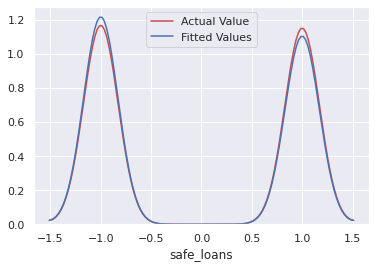

In [69]:
sns.distplot(test_data[target], hist=False, color="r", label="Actual Value")
sns.distplot(predictions, hist=False, color="b", label="Fitted Values")

## Performance Plots

Training a Boosted Ensemble of 30 Stumps

In [70]:
stump_weights, tree_stumps = adaboost_with_tree_stumps(train_data, features, target, num_tree_stumps=30)

Adaboost Iteration: 0
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature term_ 36 months. (9223, 28001)
--------------------------------------------------------------------
Subtree, depth = 2 (9223 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (28001 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration: 1
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature grade_A. (32094, 5130)
--------------------------------------------------------------------
Subtree, depth = 2 (32094 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (5130 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration: 2
------------------------------

Computing Training Error at the end of Each Iteration

In [71]:
train_error_all = []
for n in range(1, 31):
    predictions = predict_adaboost(stump_weights[:n], tree_stumps[:n], train_data)
    error = (predictions != train_data[target].values).sum()/len(train_data)
    train_error_all.append(error)
    print(f"Iteration {n}, training error = {train_error_all[n-1]}")

Iteration 1, training error = 0.4216365785514722
Iteration 2, training error = 0.4334300451321728
Iteration 3, training error = 0.40003761014399314
Iteration 4, training error = 0.40003761014399314
Iteration 5, training error = 0.3847249086610789
Iteration 6, training error = 0.38461745110681284
Iteration 7, training error = 0.3827638082957232
Iteration 8, training error = 0.38461745110681284
Iteration 9, training error = 0.3827638082957232
Iteration 10, training error = 0.38448312916398025
Iteration 11, training error = 0.3827369439071567
Iteration 12, training error = 0.3814474532559639
Iteration 13, training error = 0.38152804642166344
Iteration 14, training error = 0.3805609284332689
Iteration 15, training error = 0.38050719965613583
Iteration 16, training error = 0.3782237266279819
Iteration 17, training error = 0.378277455405115
Iteration 18, training error = 0.37841177734794756
Iteration 19, training error = 0.37806254029658287
Iteration 20, training error = 0.37876101439931226


Computing Test Error at the end of Each Iteration

In [72]:
test_error_all = []
for n in range(1, 31):
    predictions = predict_adaboost(stump_weights[:n], tree_stumps[:n], test_data)
    error = (predictions != test_data[target].values).sum()/len(test_data)
    test_error_all.append(error)
    print(f"Iteration {n}, test error = {test_error_all[n-1]}")

Iteration 1, test error = 0.4233089185695821
Iteration 2, test error = 0.42847910383455406
Iteration 3, test error = 0.3981042654028436
Iteration 4, test error = 0.3981042654028436
Iteration 5, test error = 0.3799009047824214
Iteration 6, test error = 0.38000861697544164
Iteration 7, test error = 0.3792546316242999
Iteration 8, test error = 0.38000861697544164
Iteration 9, test error = 0.3792546316242999
Iteration 10, test error = 0.3796854803963809
Iteration 11, test error = 0.3792546316242999
Iteration 12, test error = 0.37796208530805686
Iteration 13, test error = 0.3792546316242999
Iteration 14, test error = 0.3778543731150366
Iteration 15, test error = 0.3785006462731581
Iteration 16, test error = 0.3778543731150366
Iteration 17, test error = 0.37796208530805686
Iteration 18, test error = 0.3778543731150366
Iteration 19, test error = 0.37817750969409736
Iteration 20, test error = 0.3768849633778544
Iteration 21, test error = 0.37753123653597587
Iteration 22, test error = 0.3767772

**Visualizing** the Training & Test Errors

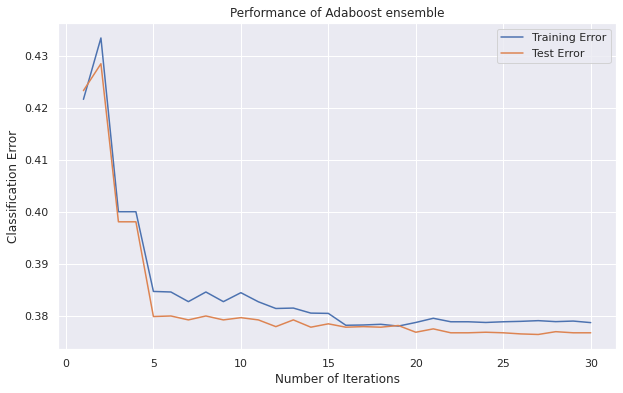

In [73]:
plt.figure(figsize=(10,6))
sns.lineplot(range(1,31), train_error_all, label='Training Error')
sns.lineplot(range(1,31), test_error_all,  label='Test Error')
plt.title('Performance of Adaboost ensemble')
plt.xlabel('Number of Iterations')
plt.ylabel('Classification Error')
plt.show()